## Generalized Orbital Amplitudes

Approximated Dyson orbitlas (or generalized orbital amplitudes, GOA)

$$g^{EKT}_k (x)= \sum_j c_{jk} n^{-1/2}_j \chi_j (x)$$

$c_{jk}$ coefﬁcients are the eigenvector solutions to EKT equation  
$n$ are the natural spin orbital occupation numbers  
$\chi_j$ are the natural orbitals

#### Setup input parameters for PyEOM (define molecular system)

In [1]:
# Import statements
import numpy as np
from iodata import load_one

# Load the molecular coordinates and MOs
mol = load_one("co_631g.molden")
mo_coeffs = mol.mo.coeffs                        # (nAOs, nMOs)
mo_coeffs_ab = np.hstack((mo_coeffs, mo_coeffs)) # Spin-up orbital, and spin-down MO coeffs

# Load the one- and two-electron integrals in the restricted MO basis
one_int = np.load('co_631g_oneint.npy') #find_datafiles
two_int = np.load('co_631g_twoint.npy')
norba = one_int.shape[0]

# Load the 1- and 2-RDMs for the HCI wfn model (non-zero spin blocks only)
dm1 = np.load("co_631g_hci_5e-4_1dm.npy") # (aa, bb)
dm2 = np.load("co_631g_hci_5e-4_2dm.npy") # (aa, bb, ab)


# Print molecule information
print("Atomic numbers \n", mol.atnums)
print("Atomic coordinates \n", mol.atcoords)
print("Number of basis functions \n", norba)
print("Number of electrons \n", np.trace(dm1[0] + dm1[1]))

Atomic numbers 
 [6 8]
Atomic coordinates 
 [[0.         0.         0.        ]
 [2.13161107 0.         0.        ]]
Number of basis functions 
 18
Number of electrons 
 13.999999999999982


In [2]:
from eomee.tools import find_datafiles, hartreefock_rdms
from eomee.tools import spinize, spinize_rdms

# Conver integrals and RDMs to generalized orbital basis
oneint = spinize(one_int) # (k,k) --> (2k, 2k) matrix dimensions
twoint = spinize(two_int) # (k,k,k,k) --> (2k, 2k, 2k, 2k) array dimensions
rdm1 = spinize_rdms(dm1)
rdm2 = spinize_rdms(dm2)

# # Generate the 1- and 2-RDMs for the Hartree-Fock wfn model
# nelecs = (7,7)
# rdm1, rdm2 = hartreefock_rdms(norba, *nelecs)

print("Spinized one int dimensions: ", oneint.shape)
print("Spinized 1RDM dimensions: ", rdm1.shape)

Spinized one int dimensions:  (36, 36)
Spinized 1RDM dimensions:  (36, 36)


In [11]:
# nto_o, w, nto_vT = np.linalg.svd(rdm1)
# occupied_nto = np.dot(mo_coeffs_ab, nto_o)
# print(w)

(36, 36)
[9.99980806e-01 9.99980806e-01 9.99962892e-01 9.99962892e-01
 9.94796909e-01 9.94796909e-01 9.88807054e-01 9.88807054e-01
 9.77756330e-01 9.77756330e-01 9.72392622e-01 9.72392621e-01
 9.72392620e-01 9.72392620e-01 3.15742379e-02 3.15742374e-02
 3.15742367e-02 3.15742359e-02 1.05780949e-02 1.05780948e-02
 5.88362018e-03 5.88362013e-03 4.10141182e-03 4.10141180e-03
 3.31491044e-03 3.31491039e-03 3.31491027e-03 3.31491027e-03
 1.57016048e-03 1.57016048e-03 7.52205389e-04 7.52205337e-04
 7.52205321e-04 7.52205300e-04 4.94774292e-04 4.94774273e-04]


##### Run an Extended Koopman's Theorem calculation

In [3]:
from eomee.ionization import EOMIP, EOMIPa

# Build de EKT matrix equation
ekt = EOMIP(oneint, twoint, rdm1, rdm2)

# Solve the EOM eigenvalue problem
ev, cv = ekt.solve_dense()

# Print the first 5 ionization energies
print("{0:<2s} {1:<6s}".format('n', 'EDiff.(a.u.)'))
for i, e in enumerate(ev[:10]):
    print("{0:<2} {1:<6.3}".format(i, e*27.12))

              These will be removed from the final solution set.
n  EDiff.(a.u.)
0  13.7  
1  13.7  
2  17.3  
3  17.3  
4  20.5  
5  20.5  
6  32.2  
7  32.2  
8  36.7  
9  36.7  


In [4]:
# Evaluate GOA
state_idx = 1
natorb_occs = np.diag(rdm1)
ncv = np.sqrt(natorb_occs) * cv[state_idx]
gao_coeffs = np.einsum("ni,i->ni", mo_coeffs_ab, ncv)


# Print molecule information
print(np.where(np.abs(ncv) > 0.01))
mask = gao_coeffs[:,:norba] > 0.01
print(gao_coeffs[:,:norba][mask])

# Pick orbital for Isosurface
idx = 6

(array([ 3,  6,  9, 12, 13, 16, 17]),)
[0.01378314 0.24403437 0.03510692 0.01282662 0.62244062 0.03158914
 0.33582341 0.11260216 0.12574587 0.02624973 0.01075664 0.02990765
 0.07060648 0.01204153 0.08799223 0.2634807  0.15431741 0.0122494
 0.05921779 0.04207764 0.01857728 0.07305319]


In [5]:
# from grid import UniformGrid

# # create a uniform grid for the molecule (interface to cube files)
# mol_grid = UniformGrid.from_molecule(mol.atnums, mol.atcoords, spacing=0.5, extension=5.0, rotate=True)

# print(f"Number of points in the molecule grid: {mol_grid.size}")

In [6]:
from gbasis.wrappers import from_iodata
from gbasis.evals.density import evaluate_basis

# Compute expected GOA values using GBasis
ao_basis = from_iodata(mol)
# mo_vals = evaluate_basis(ao_basis, mol_grid.points, transform=gao_coeffs[:,:norba].T)
# homo_vals = mo_vals[idx, :]

# mol_grid.generate_cube(
#     fname="co_goa_alpha.cube",
#     data=homo_vals,
#     atcoords=mol.atcoords,
#     atnums=mol.atnums,
#     pseudo_numbers=mol.atcorenums,
# )

Number of points in the planar grid: 1600


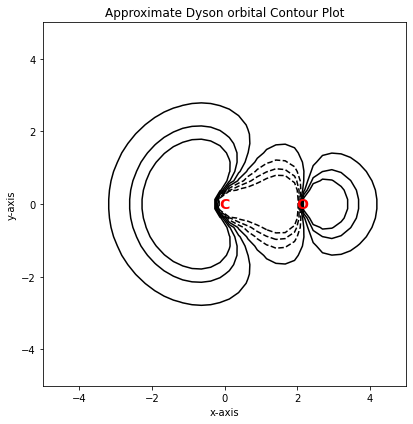

In [7]:
import matplotlib.pyplot as plt

# create a planar grid for the molecule
coord_limit = 5
plt_pts = 40
plt_lmts = [-coord_limit, coord_limit, -coord_limit, coord_limit]
x_vals = np.linspace(-coord_limit, coord_limit, plt_pts)
y_vals = x_vals

# Sample 3D points uniformly in the molecular xy-plane (z=0)
x_vals, y_vals = np.meshgrid(x_vals, y_vals)
x_vals, y_vals = x_vals.flatten(), y_vals.flatten()
z_vals = np.zeros_like(x_vals)
points = np.array([x_vals, y_vals, z_vals]).T  # gbasis evaluates at 3D points

print(f"Number of points in the planar grid: {len(points)}")

# Compute expected GOA values using GBasis
mo_vals = evaluate_basis(ao_basis, points, transform=gao_coeffs[:,:norba].T)
homo_vals = mo_vals[idx, :]

# plot the GOA as contour plot
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(111, aspect="equal")
ax1.set_title("Approximate Dyson orbital Contour Plot")
ax1.set_xlabel("x-axis")
ax1.set_ylabel("y-axis")

X = points[:, 0].reshape(plt_pts, plt_pts)
Y = points[:, 1].reshape(plt_pts, plt_pts)
Z = homo_vals.reshape(plt_pts, plt_pts)
# Add contour plot of the GOA
cs = ax1.contour(X, Y, Z, levels=np.linspace(-0.1, 0.1, 7), colors="k")
# Add atomic symbols to the plots
symbols = ["C", "O"]
xy_coords = mol.atcoords[:, :2]
for coord, symbol in zip(xy_coords, symbols):
    ax1.text(
        coord[0],
        coord[1],
        symbol,
        color="red",
        ha="center",
        va="center",
        fontsize=14,
        fontweight="bold",
    )

plt.tight_layout()  # Adjust layout for better spacing
plt.show()